**因为本地跑的太慢而且显存不够，就来kaggle白嫖GPU了（以下都是在kaggle上降低分辨率跑的结果，在本地都以小分辨率图片跑过）**

**我们组选择第二类题目**   数据集：https://www.kaggle.com/code/leyoubaloy/competition-classifyleaves<br>
| 姓名 | 角色（组长，组员，独自完成） | 工作量比例 | 负责内容 |
| --- | --- | --- | --- |
| 王元涛 | 组长 | 23 | 完成工程报告（完整版）的撰写汇总，确定工程项目为多分类任务，找到叶子分类的数据集；完成 Alexnet 算法代码实现;提供了部分模型性能评估的方法（热力图与准确度折线图） |
| 刘简华 | 组员 | 22 | 完成notebook代码的汇总（汇总模型）；提供了数据增强的方法；完成Resnet18算法代码实现；提供了模型准确率的可视化（抽出八张图作为可视化展示） |
| 董承祺 | 组员 | 19 | 完成ResNeXt101_32x8代码实现；提出了神经网络算法训练的一般步骤（前向传播与反向传播） |
| 董士豪 | 组员 | 19 | 完成了ResNet-34模型的代码实现，提出了保存最优模型的方法 |
| 丁永巍 | 组员 | 17 | 完成了resnext50_32x4d, efficientnet_b4的代码实现；探索了数据集，并且进行了一定图形化展示，清楚了解了数据集结构 |


**<font color = green>首先导入我们需要的python包</font>**  

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import copy
import time
from tqdm import tqdm
from torchvision.models import resnet34, ResNet34_Weights
import seaborn as sns
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm


**<font color = green size=12>第一大部分 数据预处理</font>**
  

  **<font color = green >1.标签数字化</font>**  
  
  首先读入数据集(由于测试集没有标签，所以将训练集作为测试集)  
  设定图片大小、批量大小等超参数(靠前放置，便于修改)  
  之后将标签从英文转化为数字，便于管理

In [2]:
# 由于test.csv内无标签，故将train.cvs当作全部数据集
root_folder = "/kaggle/input/classify-leaves"
train_csv = pd.read_csv("/kaggle/input/classify-leaves/train.csv")

# 设置，方便修改
batch_size = 128
img_size = 128 # 整合版跑不了完整分辨率（224），在此降低分辨率运行

leaves_labels = train_csv.iloc[:,1].unique()
n_classes = len(leaves_labels)
class_to_num = dict(zip(leaves_labels, range(n_classes)))
train_csv['labelEncoded'] = train_csv.iloc[:,1].map(class_to_num)

**<font color = green >2.图像预处理</font>**   

In [3]:
# 数据增强，通过水平和竖直翻转来增大数据量
train_transforms = transforms.Compose([
    transforms.Resize(img_size), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5), 
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(img_size), 
    transforms.ToTensor()
])


 
定义一个数据集类MyDataset，用来加载图像数据，并根据上述定义好的变换对图像进行预处理。  
使用train_test_split函数将数据集分割为训练集和测试集。  
创建两个DataLoader对象，用于在训练和测试过程中批量加载数据。  
打印出训练集和测试集的大小，以及类别名称，以供参考。

In [4]:
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_test = False):
        super().__init__()
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test

    @property
    def classes(self):
        return self.data.iloc[:, 1].unique().tolist()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.is_test:
            return image
        label = self.data.iloc[idx, 2]
        label = torch.tensor(label)
        return image, label
    
# 分割训练集和测试集
all_dataset = MyDataset(train_csv, root_folder, transform=train_transforms)
train_dataset, test_dataset = train_test_split(all_dataset, test_size=0.15, stratify=train_csv['label'])

# dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloaders = {'train':train_dataloader,'test':test_dataloader}

class_names = all_dataset.classes

print(f"train size:{len(train_dataset)},test size:{len(test_dataset)}")
print(all_dataset.classes)

train size:15600,test size:2753
['maclura_pomifera', 'ulmus_rubra', 'broussonettia_papyrifera', 'prunus_virginiana', 'acer_rubrum', 'cryptomeria_japonica', 'staphylea_trifolia', 'asimina_triloba', 'diospyros_virginiana', 'tilia_cordata', 'ulmus_pumila', 'quercus_muehlenbergii', 'juglans_cinerea', 'cercis_canadensis', 'ptelea_trifoliata', 'acer_palmatum', 'catalpa_speciosa', 'abies_concolor', 'eucommia_ulmoides', 'quercus_montana', 'koelreuteria_paniculata', 'liriodendron_tulipifera', 'styrax_japonica', 'malus_pumila', 'prunus_sargentii', 'cornus_mas', 'magnolia_virginiana', 'ostrya_virginiana', 'magnolia_acuminata', 'ilex_opaca', 'acer_negundo', 'fraxinus_nigra', 'pyrus_calleryana', 'picea_abies', 'chionanthus_virginicus', 'carpinus_caroliniana', 'zelkova_serrata', 'aesculus_pavi', 'taxodium_distichum', 'carya_tomentosa', 'picea_pungens', 'carya_glabra', 'quercus_macrocarpa', 'carya_cordiformis', 'catalpa_bignonioides', 'tsuga_canadensis', 'populus_tremuloides', 'magnolia_denudata', 'c

**<font color = green >3.图像处理可视化</font>**  

可视化训练集中的一批图像，并展示它们的类别名称,可以快速检查数据加载和预处理是否正确。

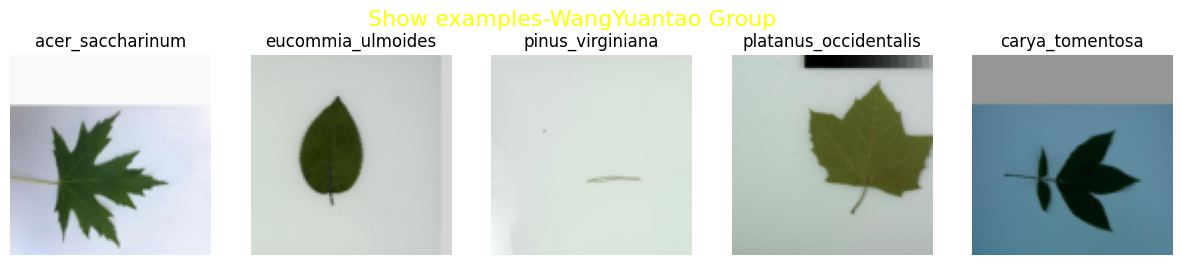

In [5]:
images, labels = next(iter(dataloaders["train"]))
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))# change the dimension order from (C, H, W) to (H, W, C),
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis('off')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.suptitle("Show examples-WangYuantao Group", fontsize=16, color='yellow')
plt.show()

**<font color = green size=12>第二大部分 模型构造、训练、测试、评估</font>**
<br>
<br>
**<font color = green size=6>王元涛</font>**

**<font color = green>1.模型构造</font>**

通过Pytorch导入alexnet  
修改alexnet最后一层的参数（本项目是176类多分类，要相匹配   
定义自己的优化器Adam

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 引入预训练好的模型模型
alexnet = models.alexnet(pretrained=True)
# 修改最后一层全连接层输出的种类：176
num_fc = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(in_features=num_fc, out_features=176)
alexnet = alexnet.to(device)
for param in alexnet.parameters():
    param.requires_grad = True
# 定义自己的优化器
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 163MB/s]  


**<font color = green>2.模型训练函数</font>**
  
通过前向传播计算loss值  
通过预测准确的数目除以总数目得到准确率  
之后再使用loss，来训练alexnet内部的参数，使得下一次迭代的准确率更高
同时记录准确率 便于生成训练集准确率曲线

In [7]:
def train(epoch, train_loader, maxNum,train_accuracies,n_epoch):
    alexnet.train()
    epoch_loss = 0.0
    correct = 0.0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        train_output = alexnet(data)
        loss = criterion(train_output, label)
        epoch_loss = epoch_loss + loss
        pred = torch.max(train_output, 1)[1]
        train_correct = (pred == label).sum()
        correct += train_correct.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_accuracies[n_epoch]=correct / len(train_dataset)
    print('Epoch: ', epoch, 'Train_loss: ', epoch_loss / len(train_dataset), 'Train acc: ', correct / len(train_dataset))
    
    if correct / len(train_dataset) > maxNum:
        maxNum = correct / len(train_dataset)
        state = {
            'state_dict' : alexnet.state_dict(), #字典里key就是各层的名字，值就是训练好的权重
            'best_acc' : maxNum,
            'optimizer' :optimizer.state_dict(),
        }
        torch.save(state, '/kaggle/working/be.pt')
    
    return maxNum

**<font color = green>3.模型测试函数</font>**
    
与训练函数的相同点：  
通过前向传播计算loss值  
通过预测准确的数目除以总数目得到准确率  
记录准确率，便于此后生成测试集准确率曲线 

与训练函数的不同点：  
开启评估模式，并且不再更新alexnet内部的参数  
记录模型预测标签与真实标签，便于生成混淆矩阵，进行混淆矩阵的可视化。

In [8]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test(test_accuracies,n_epoch):
    alexnet.eval()  # 将模型设置为评估模式
    correct = 0.0
    test_loss = 0.0
    all_labels = []  # 存储真实标签
    all_preds = []   # 存储预测标签

    with torch.no_grad():  # 禁用梯度计算
        for data, label in test_dataloader:
            data = data.to(device)
            label = label.to(device)
            test_out = alexnet(data)
            loss = criterion(test_out, label)
            test_loss += loss.item()
            pred = torch.max(test_out, 1)[1]
            all_labels.extend(label.cpu().numpy())  # 将标签添加到列表中
            all_preds.extend(pred.cpu().numpy())    # 将预测结果添加到列表中
            correct += torch.sum(pred == label).item()  # 累加正确预测的数量

    # 计算测试损失和准确率
    test_loss /= len(test_dataset)
    accuracy = correct / len(test_dataset)
    test_accuracies[n_epoch]=accuracy
    print('Test_loss: ', test_loss, 'Test acc: ', accuracy)

    # 生成混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
   # 提取前十类子矩阵
    top10_cm = cm[:10, :10]

   # 设置图形大小
    plt.figure(figsize=(10, 10))

    # 绘制热力图
    sns.heatmap(top10_cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=True, yticklabels=True, 
            square=True, 
            cbar_kws={"shrink": .75})  # 设置颜色条大小

# 设置标签和标题
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(color='yellow')
    plt.yticks(color='yellow')
    plt.title('Heatmap WangYuantao')
    # 获取当前的标题对象
    title = plt.gca().get_title()

    # 改变标题的字体颜色
    plt.title(title, color='yellow')

    # 显示图形
    plt.show()

下面的draw函数用于绘制准确度曲线

In [9]:
def draw(train_accuracies,test_accuracies,epoch):
    iterations = range(1, epoch+1)  # 假设有10次迭代
    # 创建图表
    plt.figure(figsize=(10, 5))  # 设置图形大小
    # 绘制训练准确度曲线
    plt.plot(iterations, train_accuracies, label='Training Accuracy', marker='o')

    # 绘制测试准确度曲线
    plt.plot(iterations, test_accuracies, label='Test Accuracy', marker='x')

    # 添加图例
    plt.legend()

    # 添加标题和轴标签
    plt.title('Acc WangYuantao')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    title = plt.gca().get_title()
    plt.title(title, color='yellow')

    # 优化布局并显示网格
    plt.tight_layout()
    plt.grid(True)
    plt.xticks(color='yellow')
    plt.yticks(color='yellow')

    # 显示图表
    plt.show()

**<font color = green>4.模型评估</font>**  
通过多次迭代获得每一次的准确率  
通过准确率、准确率曲线、热力图进行模型评估

Epoch:  0 Train_loss:  tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.1191025641025641
Test_loss:  0.022053099787109686 Test acc:  0.2382855067199419


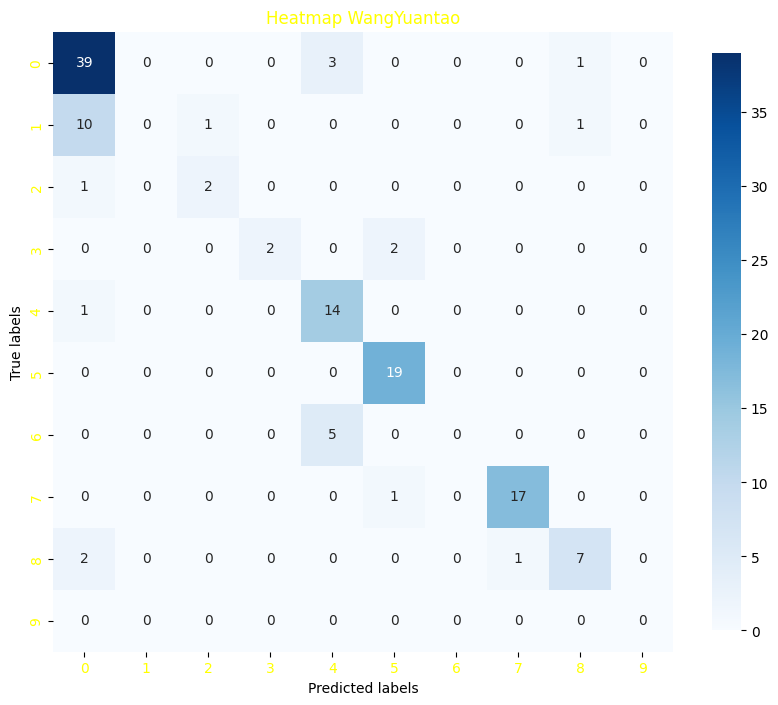

Epoch:  1 Train_loss:  tensor(0.0196, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.2948076923076923
Test_loss:  0.01776183747050115 Test acc:  0.35779150018162004


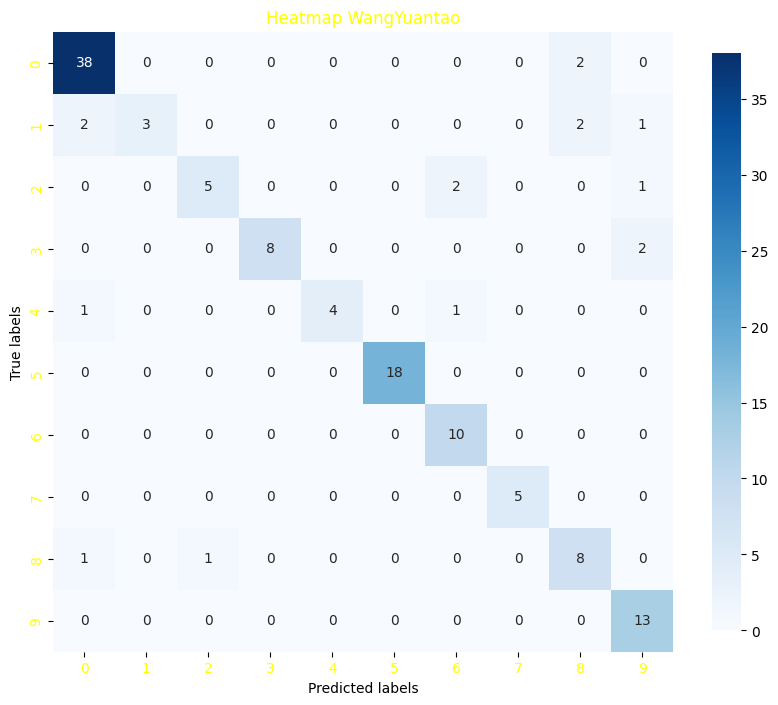

Epoch:  2 Train_loss:  tensor(0.0157, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.4010897435897436
Test_loss:  0.01736030784728871 Test acc:  0.3864874682164911


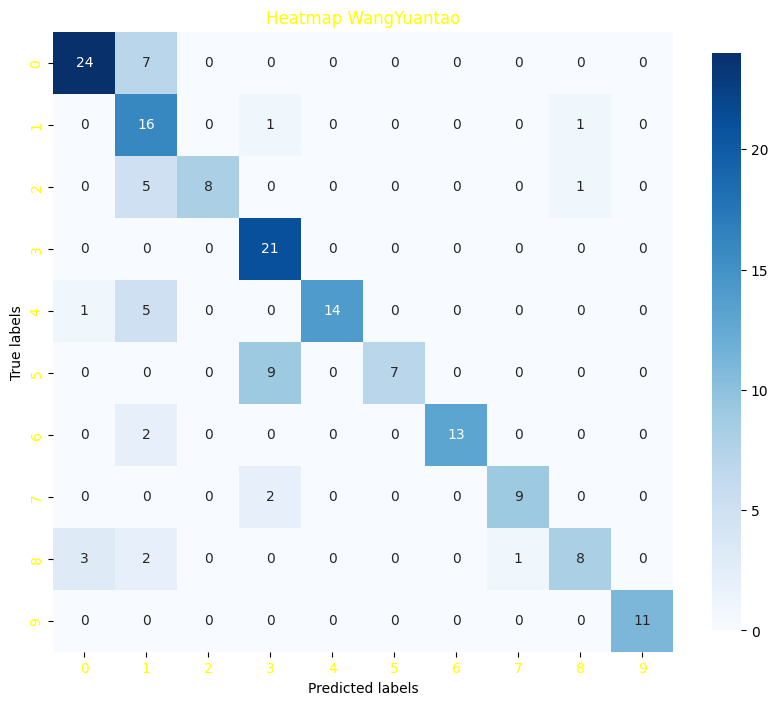

Epoch:  3 Train_loss:  tensor(0.0138, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.4593589743589744
Test_loss:  0.01465776405722455 Test acc:  0.4569560479476934


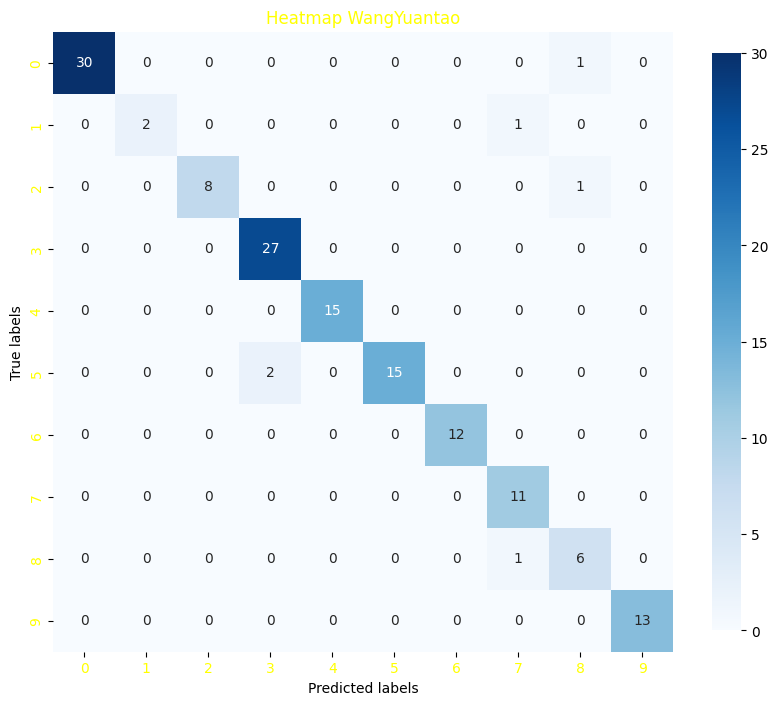

Epoch:  4 Train_loss:  tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.5178846153846154
Test_loss:  0.012985445740350238 Test acc:  0.5034507809662186


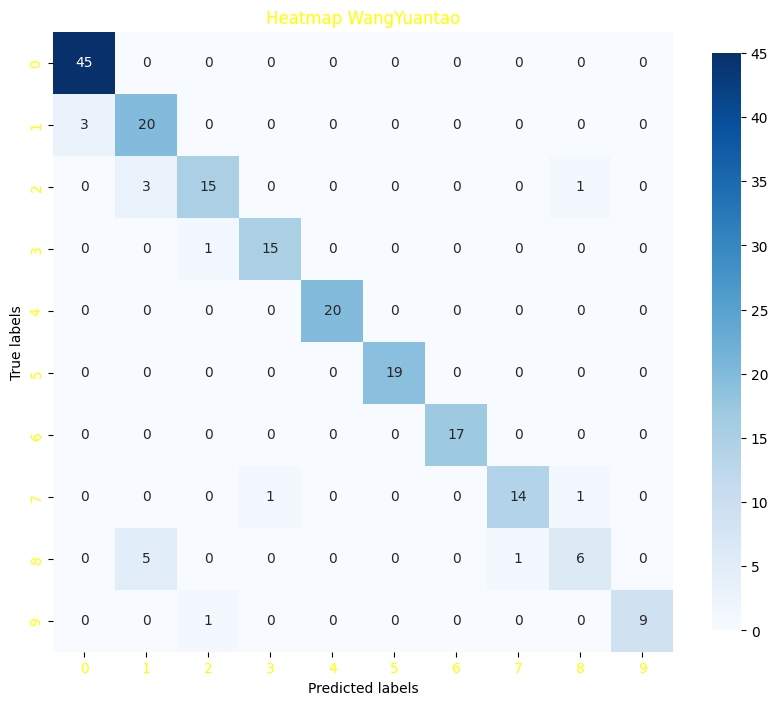

Epoch:  5 Train_loss:  tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.5648717948717948
Test_loss:  0.01291271127270561 Test acc:  0.5128950236106066


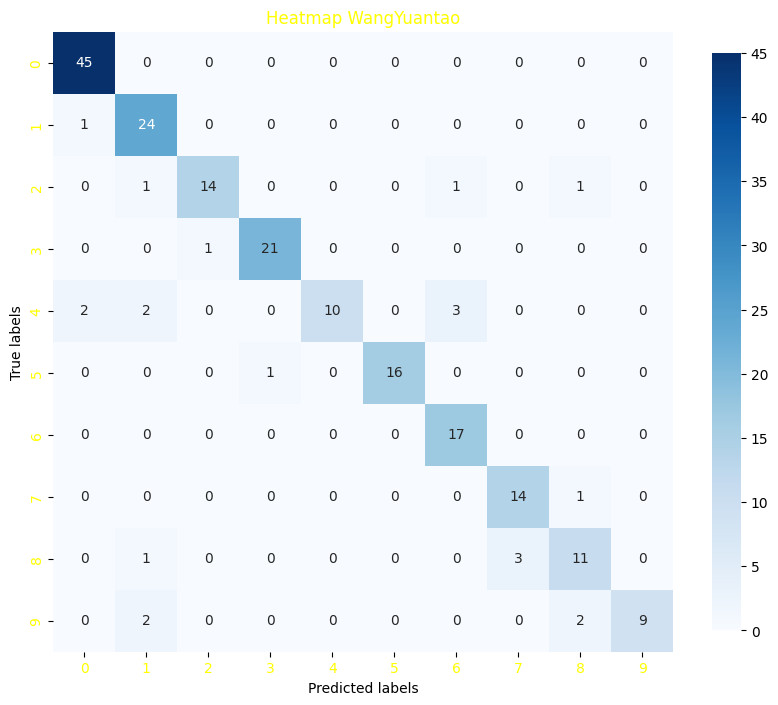

Epoch:  6 Train_loss:  tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.591025641025641
Test_loss:  0.013111571203869904 Test acc:  0.5143479840174355


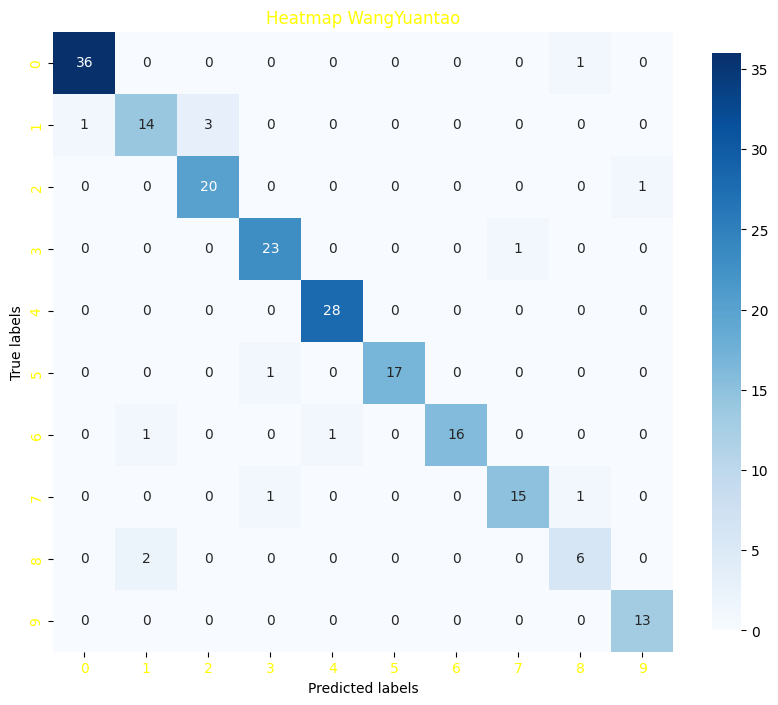

Epoch:  7 Train_loss:  tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.6357692307692308
Test_loss:  0.012430024718614738 Test acc:  0.5397747911369415


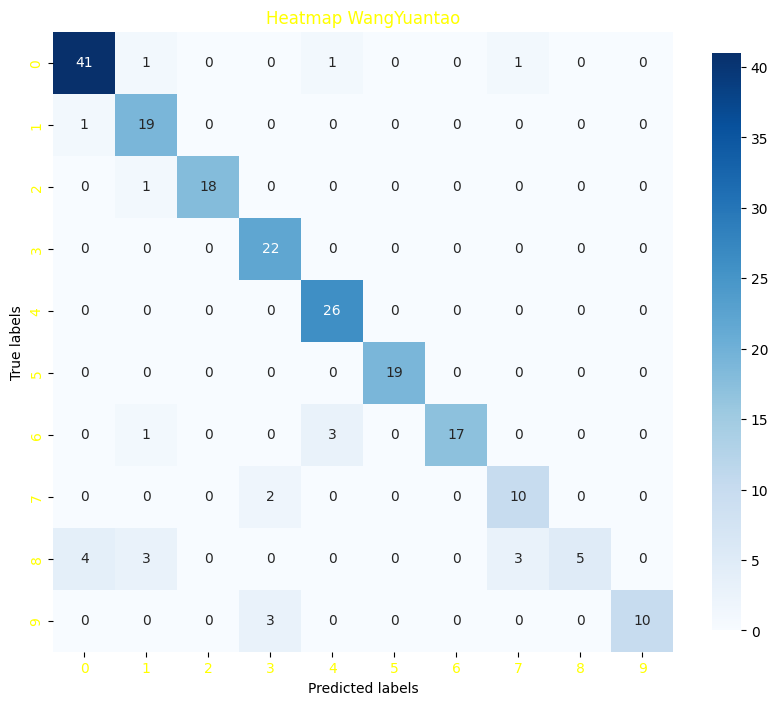

Epoch:  8 Train_loss:  tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.6616025641025641
Test_loss:  0.012571875286067654 Test acc:  0.5437704322557211


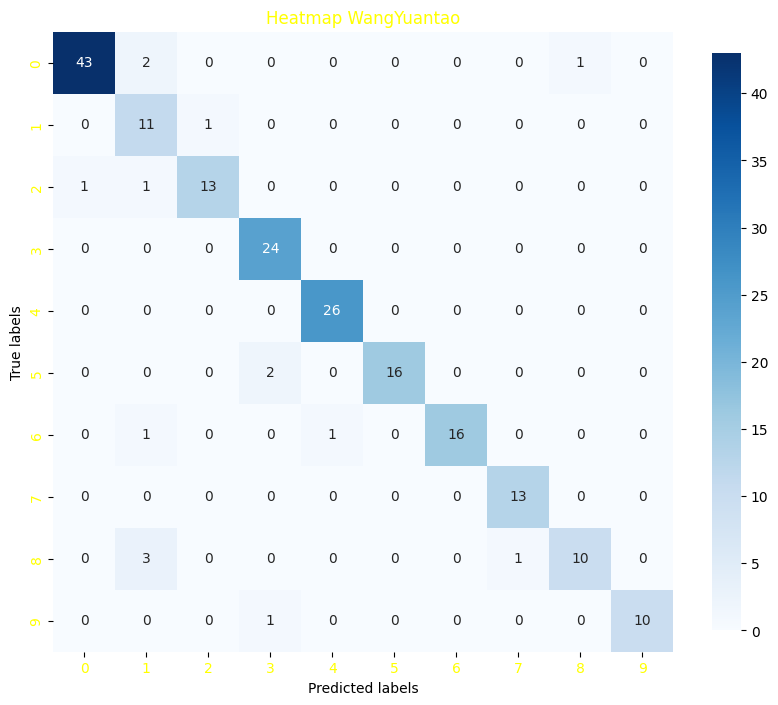

Epoch:  9 Train_loss:  tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.6886538461538462
Test_loss:  0.01150880620300315 Test acc:  0.5731928804940065


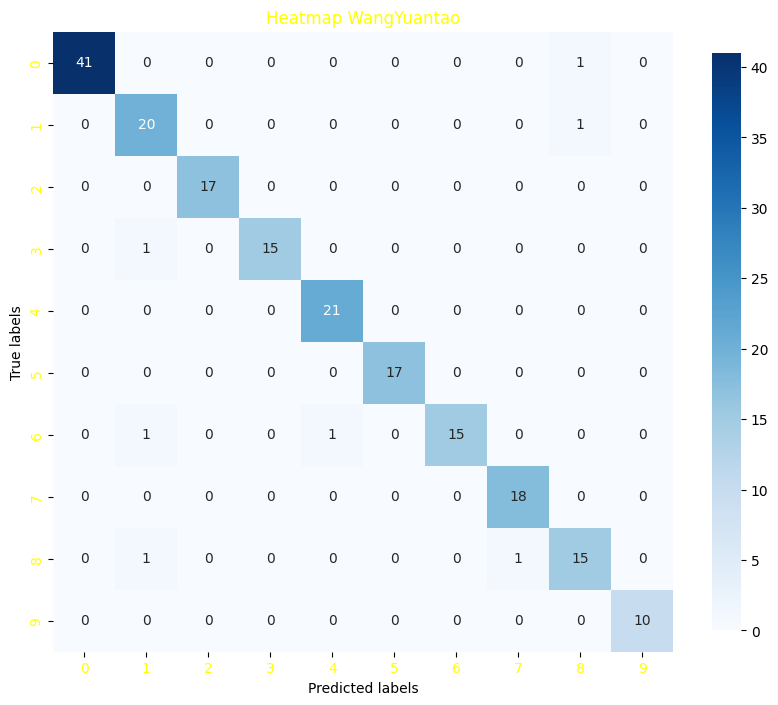

Epoch:  10 Train_loss:  tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.6996153846153846
Test_loss:  0.012637191454454027 Test acc:  0.5444969124591355


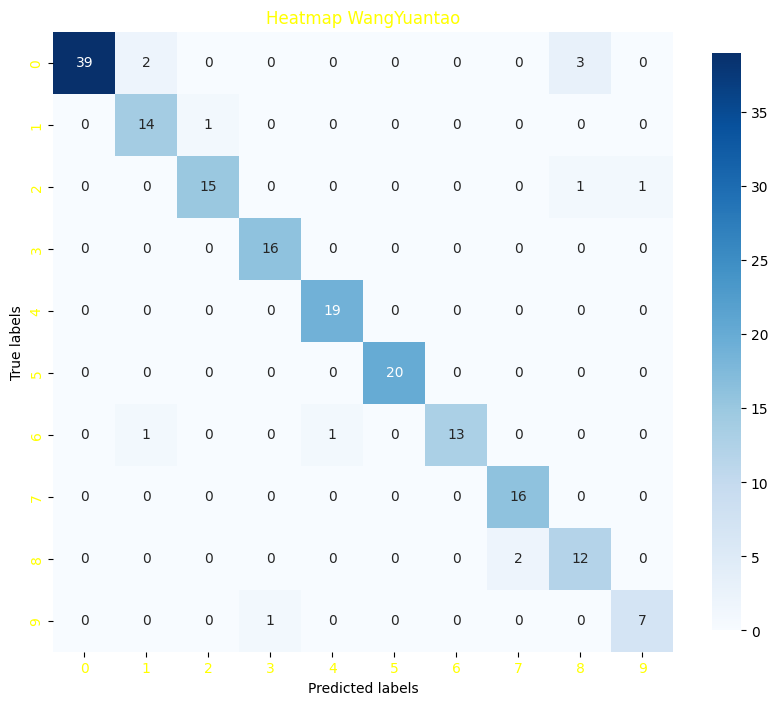

Epoch:  11 Train_loss:  tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7123076923076923
Test_loss:  0.01232214126420636 Test acc:  0.5688339992735197


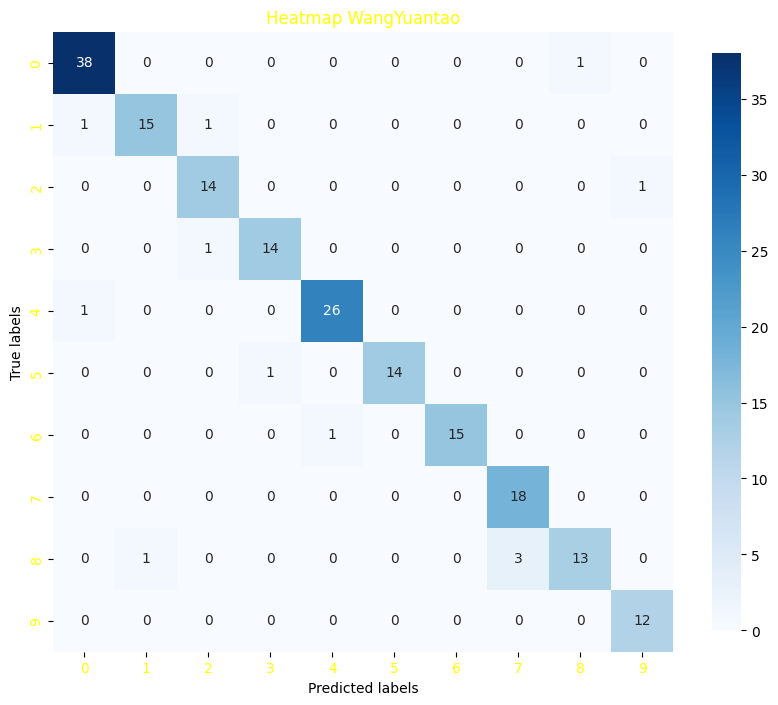

Epoch:  12 Train_loss:  tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7257692307692307
Test_loss:  0.0127517635329524 Test acc:  0.5521249545949873


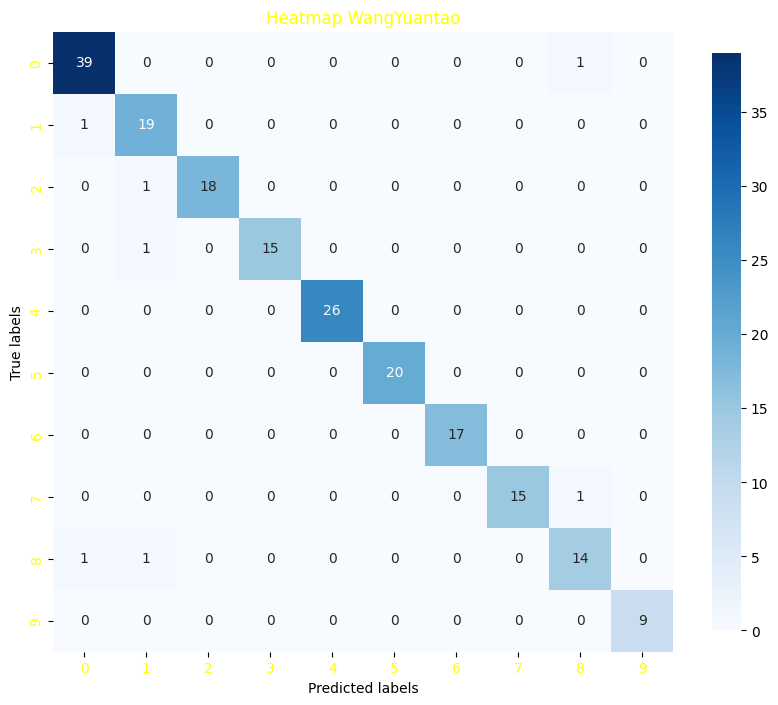

Epoch:  13 Train_loss:  tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7399358974358974
Test_loss:  0.012846701715887135 Test acc:  0.5586632764257174


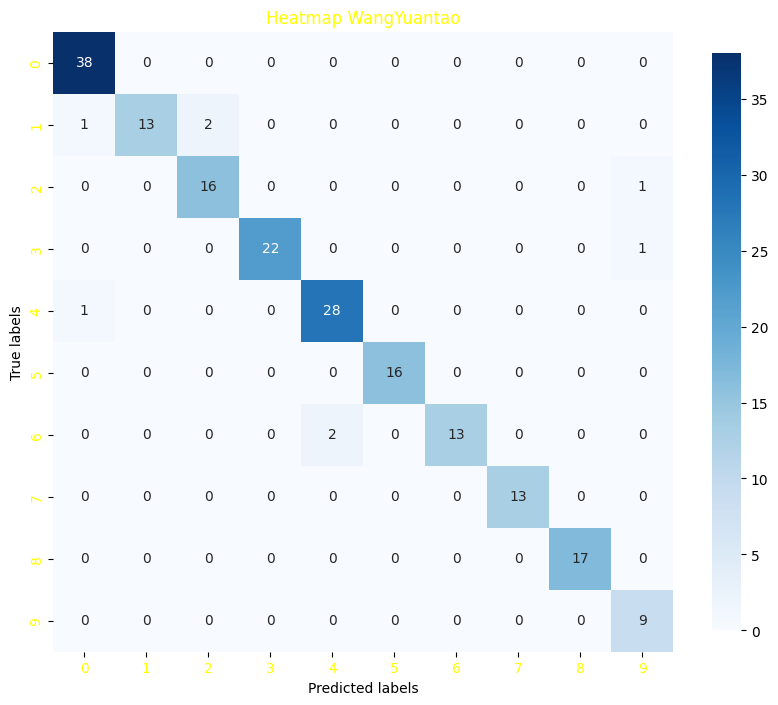

Epoch:  14 Train_loss:  tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7603846153846154
Test_loss:  0.012838877031164866 Test acc:  0.5659280784598619


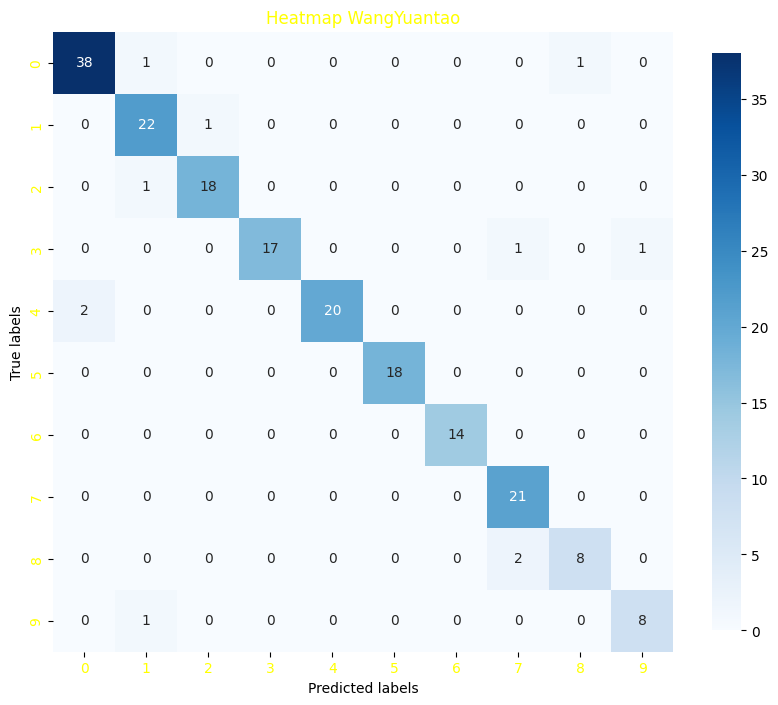

Epoch:  15 Train_loss:  tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7633333333333333
Test_loss:  0.013361600109589476 Test acc:  0.5608427170359608


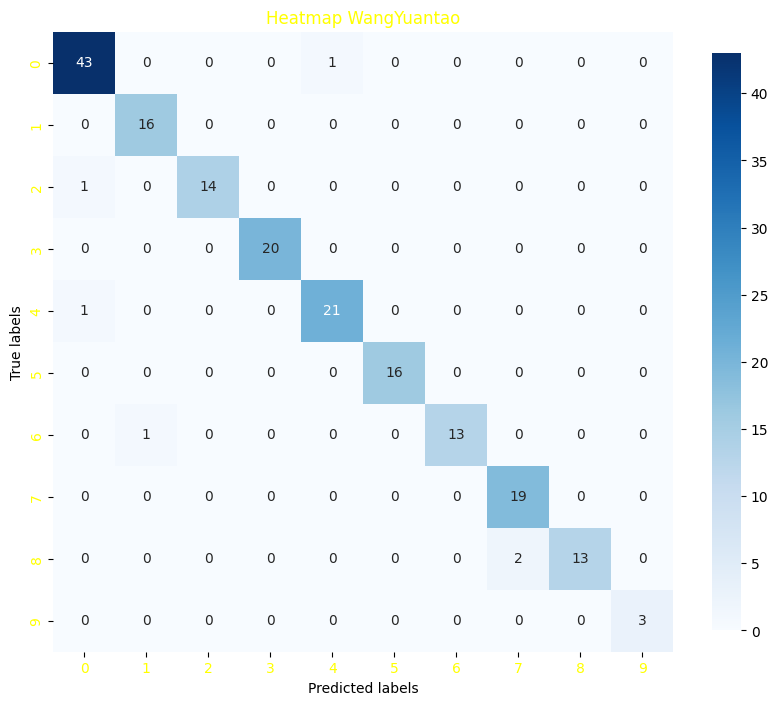

Epoch:  16 Train_loss:  tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7592948717948718
Test_loss:  0.012904082910390148 Test acc:  0.5775517617144933


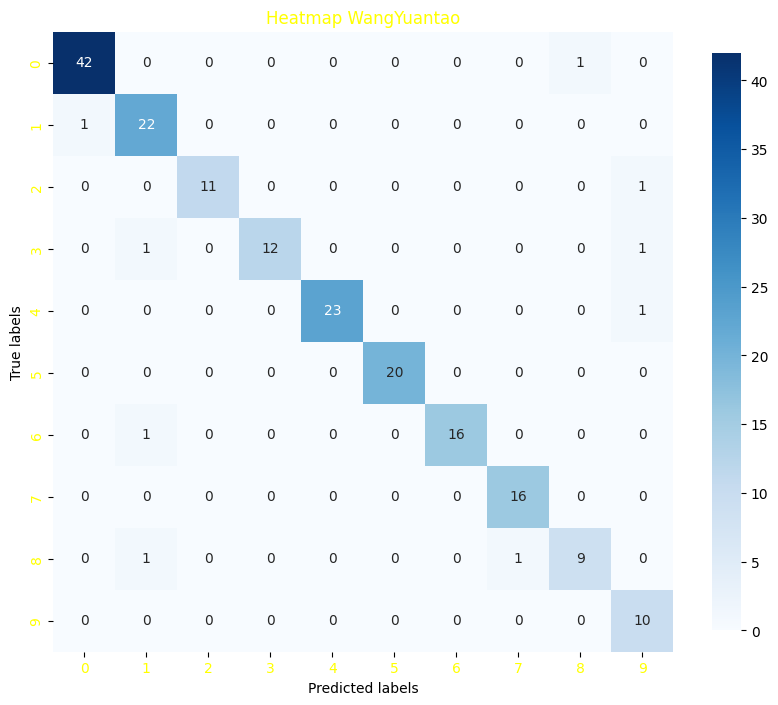

Epoch:  17 Train_loss:  tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7823076923076923
Test_loss:  0.012591619081078033 Test acc:  0.6007991282237559


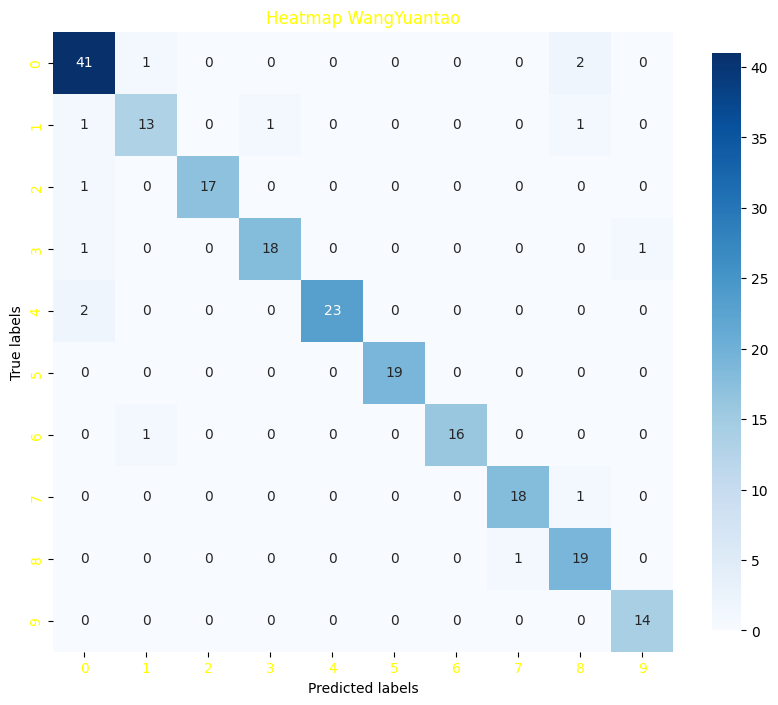

Epoch:  18 Train_loss:  tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7947435897435897
Test_loss:  0.013066896948864622 Test acc:  0.57537232110425


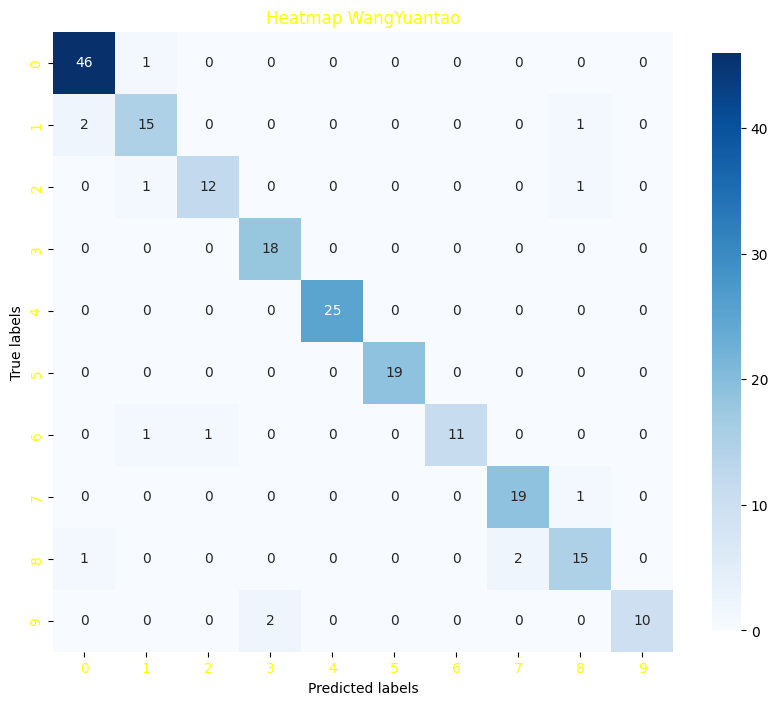

Epoch:  19 Train_loss:  tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>) Train acc:  0.7842307692307692
Test_loss:  0.012587602208667871 Test acc:  0.5855430439520523


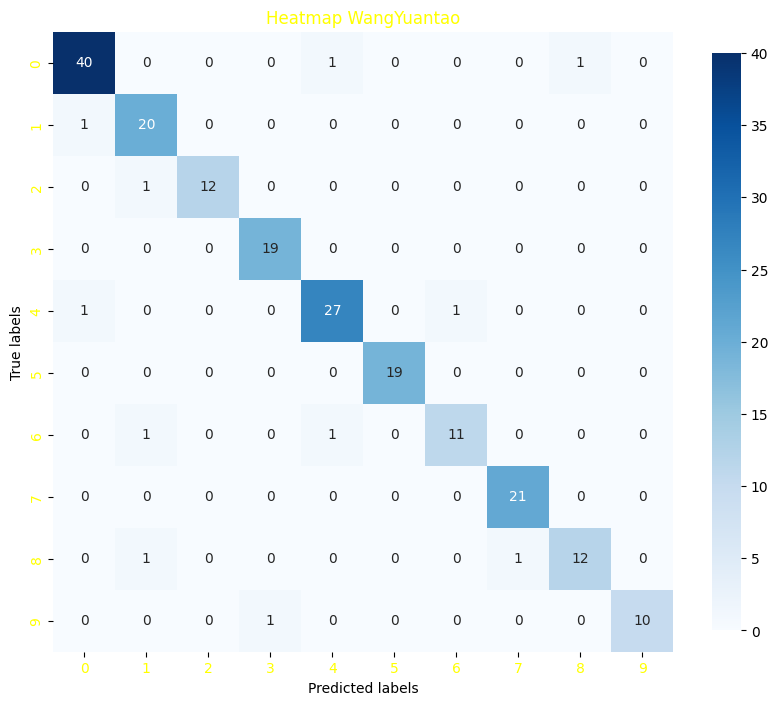

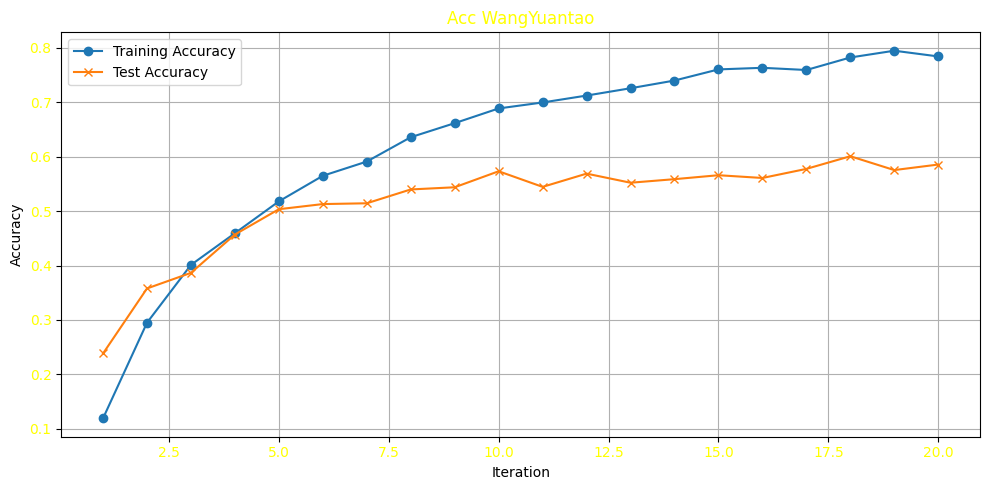

In [10]:
epoch = 20
maxNum = 0
train_accuracies = [0 for _ in range(epoch)]
test_accuracies=[0 for _ in range(epoch)]
for n_epoch in range(epoch):
    maxNum = train(n_epoch, train_dataloader, maxNum,train_accuracies,n_epoch)
    test(test_accuracies,n_epoch)
draw(train_accuracies,test_accuracies,epoch)

将此前训练好的模型导入，进行最后一次可视化的测试

In [11]:
filename = '/kaggle/working/be.pt'
#加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
alexnet.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

**<font color = green>测试可视化</font>**   

进行十组测试的评估，取平均准确率作为模型准确率  
在最后一组评估中随机取8张图片，展示出来，使我们对模型准确率有更直观地感知

0.59296875


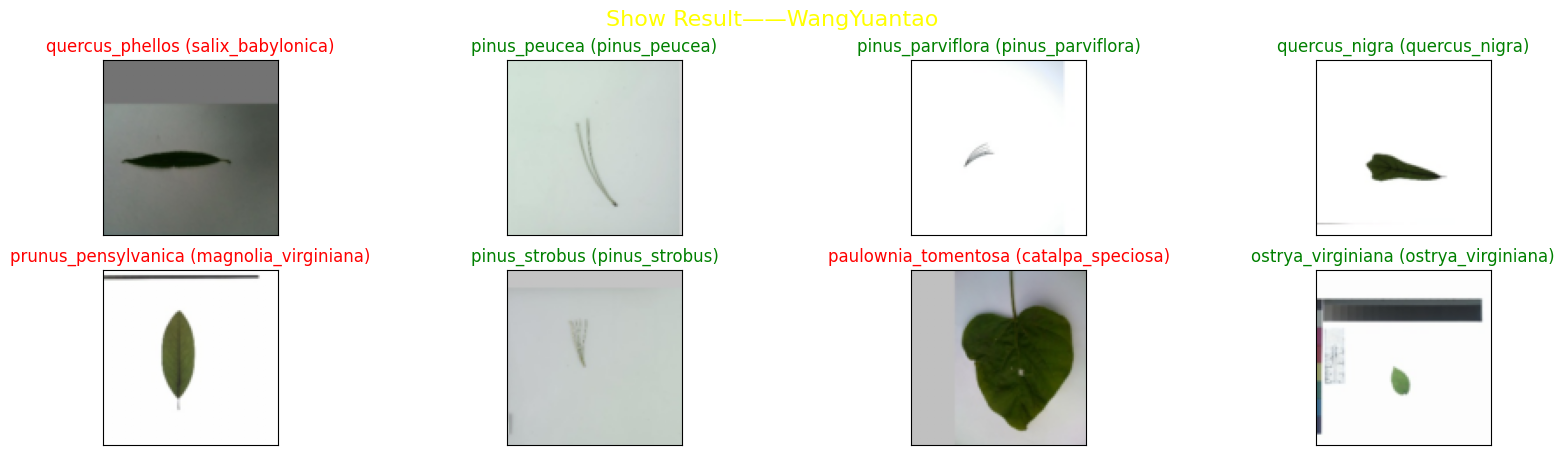

In [41]:
fig=plt.figure(figsize=(20, 5))
average = 0
train_on_gpu = torch.cuda.is_available()
for times in range(10):
    dataiter = iter(dataloaders['test'])
    images, labels = next(dataiter)
    alexnet.eval()
    if train_on_gpu:
        output = alexnet(images.cuda())
    else:
        output = alexnet(images)
        
    _, preds_tensor=torch.max(output, 1)

    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    def im_convert(tensor):
        image =tensor.to("cpu").clone().detach()
        image = image.numpy().squeeze()
        image =image.transpose(1, 2,0)
        image =image.clip(0, 1)
        return image      

    
    columns=4
    rows=2

    correct = 0
    for i in range(len(preds)):
        if class_names[preds[i]]==class_names[labels[i]]:
            correct += 1
    average+=correct/len(preds)

average /= 10
print(average)

for idx in range(columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
            color=("green" if class_names[preds[idx]]==class_names[labels[idx]] else "red"))
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.suptitle("Show Result——WangYuantao", fontsize=16,color='yellow')
plt.show()

**<font color = green size=6>刘简华</font>**

**导入预训练好的模型**

In [13]:
# 一些设置，方便修改
batch_size = 128
img_size = 224
epochs = 30

feature_extract = True
model_name = 'resnet'
model_ft = models.resnet18()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu = torch.cuda.is_available()

#冻结参数
def set_parameter_requires_grad(model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                  param.requires_grad = False

def initialize_model(feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)   # 下载一个预训练好的模型
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))  
    return model_ft

model_ft = initialize_model(feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

# 模型保存
filename = '/kaggle/working/best.pt'
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update=[]
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s] 


**设置训练函数**<br>
保存最好的一次训练效果的模型，保存到本地并画出过程的折线图

In [14]:
#优化器设置
optimizer_ft = optim.Adam(params_to_update,lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft,step_size=15,gamma=0.1)  #学习率每15个epoch装减成原来的1/10
criterion = nn.CrossEntropyLoss()

def train_model(model, dataloaders, criterion, optimizer, num_epochs, filename='best.pt'):
    since = time.time()
    best_acc = 0
    model.to(device)
    
    train_accuracies = []
    test_accuracies = []
    LRs = [optimizer.param_groups[0]['lr']]
    
    # 保存最好的那次模型
    best_model_wts = copy.deepcopy(model.state_dict())

    # 遍历
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch + 1,num_epochs))
        print('-' * 10)
        for phase in ['train','test']:
            if phase =='train':
                model.train()
            else:
                model.eval()
            
            running_loss =0.0
            running_corrects=0

            #把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs=model(inputs)
                loss = criterion(outputs,labels)
                _,preds =torch.max(outputs, 1)

                #更新权重
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item()*inputs.size(0)          # 计算损失
                running_corrects += torch.sum(preds== labels.data)  # 预测结果正确的数量

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            scheduler.step()

            time_elapsed=time.time()-since

            if phase=='test':
                print('测试集:  Loss:{:.4f}, 准确率:{:.4f}'.format(epoch_loss, epoch_acc))
                test_accuracies.append(epoch_acc.data.cpu())
            else:
                print( '耗时 {:.0f}m {:.0f}s'.format(time_elapsed //60, time_elapsed % 60))
                print('训练集:  Loss:{:.4f}, 准确率:{:.4f}'.format(epoch_loss, epoch_acc))
                train_accuracies.append(epoch_acc.data.cpu()) # 要转换成cpu类型的数据

            #得到最好那次的模型
            if phase =='test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict' : model.state_dict(),
                    'best_acc' : best_acc,
                    'optimizer' :optimizer.state_dict(),
                }
                torch.save(state, filename)

        print('学习率 : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])

        print()

    time_elapsed =time.time() - since
    print('Training_complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best_val_Acc:{:.4f}'.format(best_acc))

    #画折线图
    iterations = range(1, num_epochs+1) 
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(iterations, test_accuracies, label='Test Accuracy', marker='x')
    plt.legend()
    plt.title('Training and Test Accuracies Over Iterations -- LiuJianhua')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
    #训练完后用最好的一次当做模型最终的结果。等着一会测试
    model.load_state_dict(best_model_wts)
    return model, LRs

**第一次训练**

Epoch1/30
----------
耗时 0m 3s
训练集:  Loss:3.4783, 准确率:0.3110
测试集:  Loss:2.6899, 准确率:0.4224
学习率 : 0.0100000

Epoch2/30
----------
耗时 0m 6s
训练集:  Loss:1.8488, 准确率:0.5481
测试集:  Loss:2.4809, 准确率:0.4613
学习率 : 0.0100000

Epoch3/30
----------
耗时 0m 9s
训练集:  Loss:1.4737, 准确率:0.6230
测试集:  Loss:2.2778, 准确率:0.5005
学习率 : 0.0100000

Epoch4/30
----------
耗时 0m 13s
训练集:  Loss:1.2328, 准确率:0.6751
测试集:  Loss:2.3773, 准确率:0.5336
学习率 : 0.0100000

Epoch5/30
----------
耗时 0m 16s
训练集:  Loss:1.0846, 准确率:0.7078
测试集:  Loss:2.3533, 准确率:0.5329
学习率 : 0.0100000

Epoch6/30
----------
耗时 0m 19s
训练集:  Loss:0.9535, 准确率:0.7402
测试集:  Loss:2.3555, 准确率:0.5423
学习率 : 0.0100000

Epoch7/30
----------
耗时 0m 22s
训练集:  Loss:0.8888, 准确率:0.7520
测试集:  Loss:2.3778, 准确率:0.5503
学习率 : 0.0100000

Epoch8/30
----------
耗时 0m 26s
训练集:  Loss:0.8378, 准确率:0.7713
测试集:  Loss:2.5308, 准确率:0.5496
学习率 : 0.0010000

Epoch9/30
----------
耗时 0m 29s
训练集:  Loss:0.3699, 准确率:0.8854
测试集:  Loss:1.9614, 准确率:0.6131
学习率 : 0.0010000

Epoch10/30
----------
耗时 0m 32s

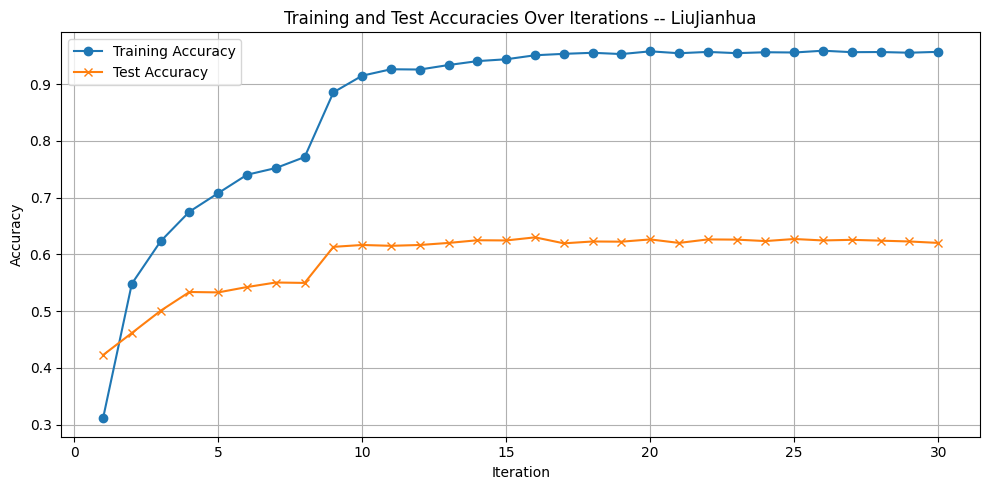

In [15]:
model_ft, LRs = train_model(model_ft, dataloaders, criterion, optimizer_ft, epochs, filename)

**解冻参数，可手动调整学习率进行多次训练**

Epoch1/15
----------
耗时 0m 7s
训练集:  Loss:2.1617, 准确率:0.4746
测试集:  Loss:1.7005, 准确率:0.5285
学习率 : 0.0010000

Epoch2/15
----------
耗时 0m 15s
训练集:  Loss:0.9101, 准确率:0.7172
测试集:  Loss:1.3167, 准确率:0.6306
学习率 : 0.0010000

Epoch3/15
----------
耗时 0m 23s
训练集:  Loss:0.6280, 准确率:0.7969
测试集:  Loss:2.3076, 准确率:0.4947
学习率 : 0.0010000

Epoch4/15
----------
耗时 0m 31s
训练集:  Loss:0.4837, 准确率:0.8429
测试集:  Loss:1.4168, 准确率:0.6270
学习率 : 0.0010000

Epoch5/15
----------
耗时 0m 39s
训练集:  Loss:0.3690, 准确率:0.8809
测试集:  Loss:1.9728, 准确率:0.5568
学习率 : 0.0010000

Epoch6/15
----------
耗时 0m 47s
训练集:  Loss:0.2912, 准确率:0.9063
测试集:  Loss:1.7851, 准确率:0.6139
学习率 : 0.0010000

Epoch7/15
----------
耗时 0m 54s
训练集:  Loss:0.2427, 准确率:0.9219
测试集:  Loss:1.6581, 准确率:0.6313
学习率 : 0.0010000

Epoch8/15
----------
耗时 1m 2s
训练集:  Loss:0.2394, 准确率:0.9228
测试集:  Loss:1.8280, 准确率:0.6030
学习率 : 0.0010000

Epoch9/15
----------
耗时 1m 10s
训练集:  Loss:0.1929, 准确率:0.9356
测试集:  Loss:1.1152, 准确率:0.7265
学习率 : 0.0010000

Epoch10/15
----------
耗时 1m 18

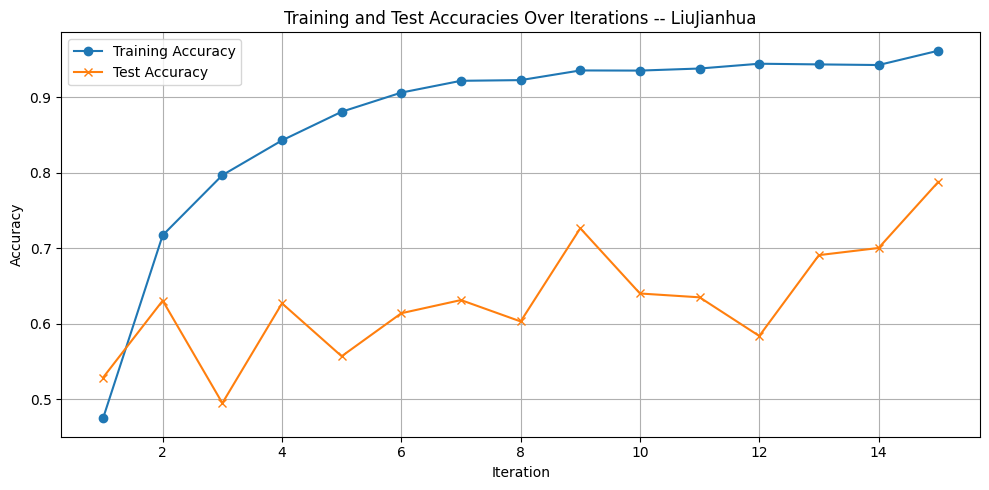

Epoch1/5
----------
耗时 0m 7s
训练集:  Loss:0.0909, 准确率:0.9696
测试集:  Loss:1.6028, 准确率:0.6887
学习率 : 0.0010000

Epoch2/5
----------
耗时 0m 15s
训练集:  Loss:0.1129, 准确率:0.9646
测试集:  Loss:2.4170, 准确率:0.5587
学习率 : 0.0010000

Epoch3/5
----------
耗时 0m 23s
训练集:  Loss:0.0966, 准确率:0.9688
测试集:  Loss:1.1021, 准确率:0.7566
学习率 : 0.0010000

Epoch4/5
----------
耗时 0m 31s
训练集:  Loss:0.1121, 准确率:0.9637
测试集:  Loss:1.4032, 准确率:0.6887
学习率 : 0.0010000

Epoch5/5
----------
耗时 0m 39s
训练集:  Loss:0.1578, 准确率:0.9521
测试集:  Loss:1.9573, 准确率:0.6052
学习率 : 0.0010000

Training_complete in 0m 39s
Best_val_Acc:0.7566


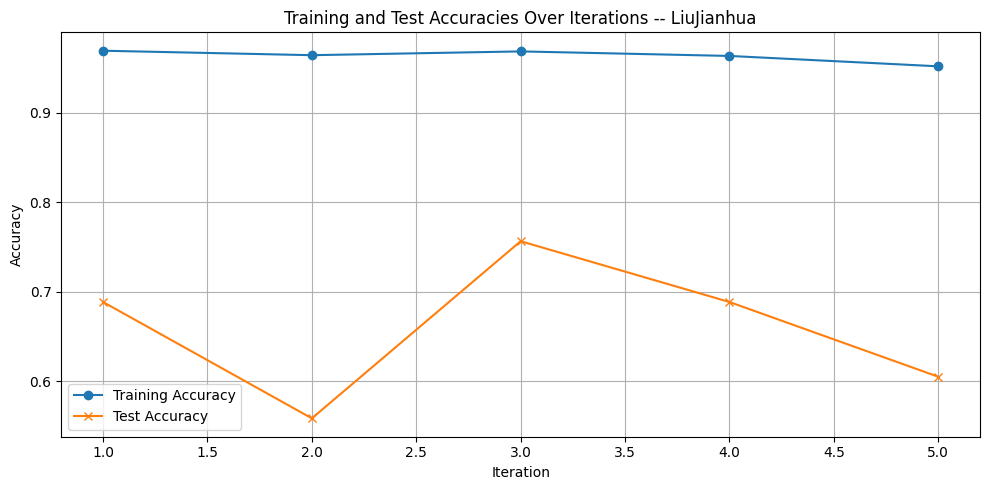

Epoch1/5
----------
耗时 0m 7s
训练集:  Loss:0.0288, 准确率:0.9897
测试集:  Loss:0.4749, 准确率:0.8769
学习率 : 0.0001000

Epoch2/5
----------
耗时 0m 15s
训练集:  Loss:0.0086, 准确率:0.9972
测试集:  Loss:0.4306, 准确率:0.8849
学习率 : 0.0001000

Epoch3/5
----------
耗时 0m 23s
训练集:  Loss:0.0076, 准确率:0.9974
测试集:  Loss:0.4138, 准确率:0.8896
学习率 : 0.0001000

Epoch4/5
----------
耗时 0m 31s
训练集:  Loss:0.0065, 准确率:0.9975
测试集:  Loss:0.4155, 准确率:0.8928
学习率 : 0.0001000

Epoch5/5
----------
耗时 0m 39s
训练集:  Loss:0.0073, 准确率:0.9972
测试集:  Loss:0.4098, 准确率:0.8918
学习率 : 0.0001000

Training_complete in 0m 40s
Best_val_Acc:0.8928


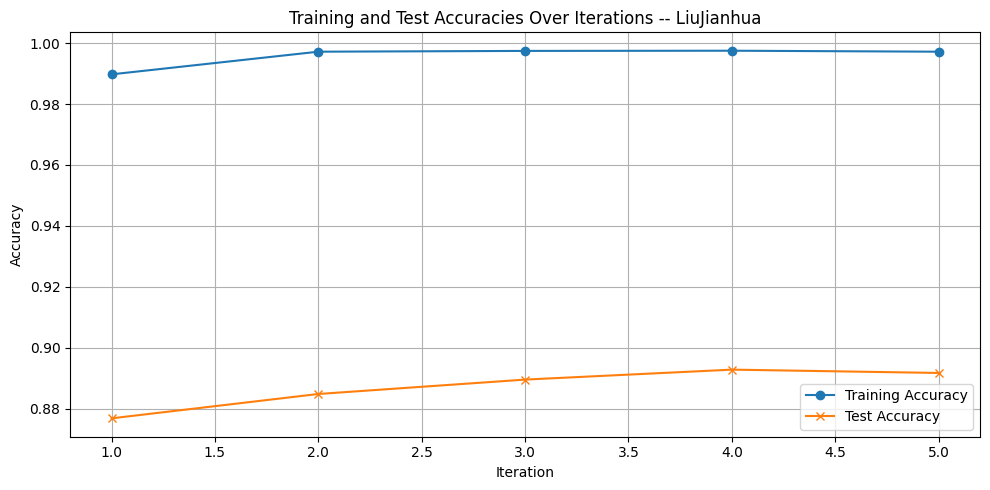

In [16]:
#解冻参数
for param in model_ft.parameters():
    param.requires_grad = True
    
#训练所有的参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
criterion =nn.CrossEntropyLoss()

#加载之前训练好的权重参数
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

model_ft, LRs = train_model(model_ft, dataloaders, criterion, optimizer, 15, filename)
model_ft, LRs = train_model(model_ft, dataloaders, criterion, optimizer, 5, filename)
optimizer = optim.Adam(model_ft.parameters(), lr=1e-4)
model_ft, LRs = train_model(model_ft, dataloaders, criterion, optimizer, 5, filename)

**结果展示**<br>
    取1400张测试数据（太多会爆显存），随机展示8张预测结果

GPU:0
process       3162 uses     2446.000 MB GPU memory
准确率: 0.8928571428571429


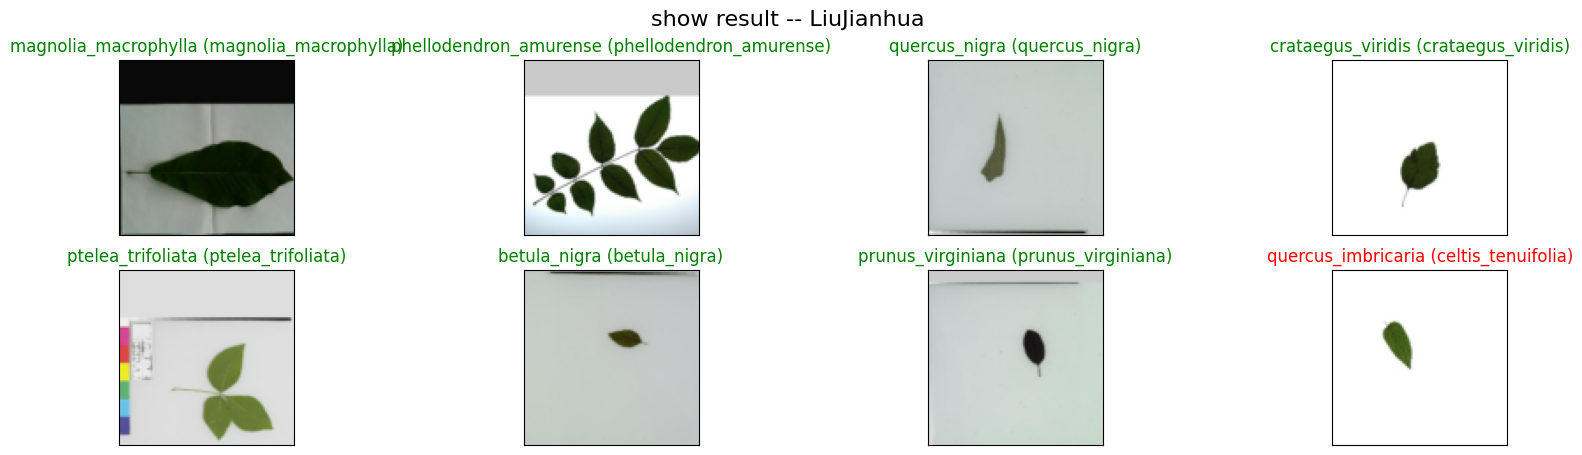

In [17]:
model_ft = initialize_model(feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)
#加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

fig=plt.figure(figsize=(20, 5))
average = 0

#释放cuda缓存，不然一次跑完整个数据集会超显存
import gc
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

test_dataloader = DataLoader(test_dataset, batch_size=1400, shuffle=True)
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
model_ft.eval()
if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

_, preds_tensor=torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

def im_convert(tensor):
    image =tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image =image.transpose(1, 2,0)
    image =image.clip(0, 1)
    return image

correct = 0
for i in range(len(preds)):
    if class_names[preds[i]]==class_names[labels[i]]:
        correct += 1
        
average=correct/len(preds)
print("准确率:",average)

columns=4
rows=2

for idx in range(columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
            color=("green" if class_names[preds[idx]]==class_names[labels[idx]] else "red"))
plt.suptitle("show result -- LiuJianhua", fontsize=16)
plt.show()

**<font color = green size=6>董士豪</font>**

In [18]:
# 构建模型
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
# resnet34模型
def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [19]:
# 确定使用设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
# 设置训练参数
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 10
model_path = '/kaggle/working/pre_res_model.ckpt'

In [21]:
# 初始化模型
model = res_model(176)
model = model.to(device)
model.device = device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 150MB/s] 


In [22]:
# 设置损失函数
criterion = nn.CrossEntropyLoss()

In [23]:
#设置优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [24]:
# 模型训练
n_epochs = num_epoch
best_acc = 0.0
for epoch in range(n_epochs):
    # 开始训练
    model.train()
    #记录数值
    train_loss = []
    train_accs = []
    for batch in tqdm(train_dataloader):
        # 一个batch的图片和label
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # 前向传播
        logits = model(imgs)
        #获得损失值
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        # 反向传播，更新参数
        loss.backward()
        optimizer.step()

        # 计算准确率
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # 追加数值
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # 打印训练过程信息
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # 模型验证
    model.eval()
    # 记录数值
    valid_loss = []
    valid_accs = []
    for batch in tqdm(test_dataloader):
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))

        
        loss = criterion(logits, labels.to(device))

        # 计算每个batch的准确率
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # 追加数值
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    # 打印信息
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))
        

100%|██████████| 122/122 [00:11<00:00, 10.56it/s]


[ Train | 001/010 ] loss = 2.42361, acc = 0.42936


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 001/010 ] loss = 1.66837, acc = 0.52791
saving model with acc 0.528


100%|██████████| 122/122 [00:11<00:00, 10.58it/s]


[ Train | 002/010 ] loss = 0.87100, acc = 0.75168


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 002/010 ] loss = 1.64327, acc = 0.53622
saving model with acc 0.536


100%|██████████| 122/122 [00:11<00:00, 10.57it/s]


[ Train | 003/010 ] loss = 0.49721, acc = 0.85562


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 003/010 ] loss = 1.04425, acc = 0.70022
saving model with acc 0.700


100%|██████████| 122/122 [00:11<00:00, 10.57it/s]


[ Train | 004/010 ] loss = 0.34062, acc = 0.89941


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


[ Valid | 004/010 ] loss = 0.74713, acc = 0.77676
saving model with acc 0.777


100%|██████████| 122/122 [00:11<00:00, 10.57it/s]


[ Train | 005/010 ] loss = 0.28031, acc = 0.91812


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 005/010 ] loss = 1.01511, acc = 0.72133


100%|██████████| 122/122 [00:11<00:00, 10.58it/s]


[ Train | 006/010 ] loss = 0.24595, acc = 0.92566


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 006/010 ] loss = 0.81164, acc = 0.76396


100%|██████████| 122/122 [00:11<00:00, 10.58it/s]


[ Train | 007/010 ] loss = 0.22196, acc = 0.93333


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 007/010 ] loss = 0.88923, acc = 0.73579


100%|██████████| 122/122 [00:11<00:00, 10.57it/s]


[ Train | 008/010 ] loss = 0.18907, acc = 0.94562


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 008/010 ] loss = 0.82466, acc = 0.76118


100%|██████████| 122/122 [00:11<00:00, 10.57it/s]


[ Train | 009/010 ] loss = 0.21217, acc = 0.93784


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[ Valid | 009/010 ] loss = 0.97116, acc = 0.72888


100%|██████████| 122/122 [00:11<00:00, 10.58it/s]


[ Train | 010/010 ] loss = 0.16480, acc = 0.95147


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

[ Valid | 010/010 ] loss = 0.67815, acc = 0.80750
saving model with acc 0.808


In [25]:
def display_data(dataloader,class_names):
    images, labels = next(iter(dataloader["train"]))
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axes[i].imshow(images[i].permute(1, 2, 0))# change the dimension order from (C, H, W) to (H, W, C),
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.show()

    images, labels = next(iter(dataloader["train"]))
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axes[i].imshow(images[i].permute(1, 2, 0))# change the dimension order from (C, H, W) to (H, W, C),
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.show()

准确率: 0.8957142857142857


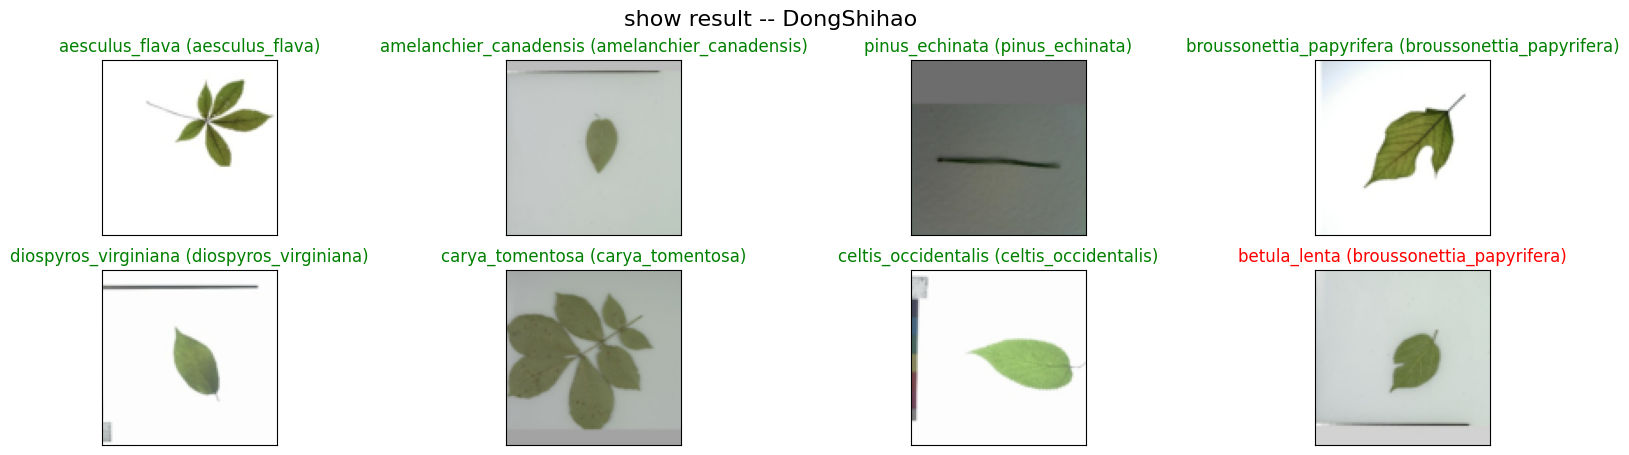

In [26]:
model_ft = initialize_model(feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)
#加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

fig=plt.figure(figsize=(20, 5))
average = 0

#释放cuda缓存，不然一次跑完整个数据集会超显存
import gc
gc.collect()
torch.cuda.empty_cache()

test_dataloader = DataLoader(test_dataset, batch_size=1400, shuffle=True)
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
model_ft.eval()
if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

_, preds_tensor=torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

def im_convert(tensor):
    image =tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image =image.transpose(1, 2,0)
    image =image.clip(0, 1)
    return image

correct = 0
for i in range(len(preds)):
    if class_names[preds[i]]==class_names[labels[i]]:
        correct += 1
        
average=correct/len(preds)
print("准确率:",average)

columns=4
rows=2

for idx in range(columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
            color=("green" if class_names[preds[idx]]==class_names[labels[idx]] else "red"))
plt.suptitle("show result -- DongShihao", fontsize=16)
plt.show()

**<font color = green size=6>董承祺</font>**<br>
安装 timm 包，用于加载预训练模型。<br>
安装 ttach 包，用于数据增强，增强模型泛化性<br>
定义了一些超参数，用于控制模型的训练过程。

In [27]:
!pip install timm 
!pip install ttach
learning_rate = 1e-4   #1e-4
weight_decay = 1e-3
num_epoch = 10
train_accuracies = [0 for _ in range(num_epoch)]
test_accuracies=[0 for _ in range(num_epoch)]
beta = 1              #cutmix参数
model_path = './pre_res_model.ckpt' #保存中间模型数据，方便加载


使用了timm库来加载预训练的模型。导入Python的prettyprint模块，用于以更美观的方式打印Python对象。创建了convit_tiny和cait_xxs24_224两个预训练模型。

In [28]:
import timm
import pprint
model1 = timm.create_model('convit_tiny', pretrained=True)
model2  = timm.create_model('cait_xxs24_224',pretrained=True)

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.9M [00:00<?, ?B/s]

定义了损失函数、优化器和学习率调度器，学习率调度器scheduler使用ReduceLROnPlateau策略。这个策略会在某个指标（如损失）停止下降时减少学习率。scheduler的参数包括优化器、模式（min表示指标不再降低时减少学习率，max表示指标不再升高时减少学习率）、调整倍数、耐心、是否打印信息等。

In [29]:
from torch import optim
# loss and  optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(),lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', 
    cooldown=0, min_lr=0, eps=1e-08
)

创建了resnext101_32x8d预训练模型

In [30]:
model3 = timm.create_model('resnext101_32x8d',pretrained=True)

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

修改了model3的最后一层，将其输出特征的数量从模型的默认设置调整为176。然后，使用nn.init.xavier_uniform_函数初始化最后一层的权重

In [31]:
model3.fc = nn.Linear(model3.fc.in_features,176)
nn.init.xavier_uniform_(model3.fc.weight)
model3 = model3.to(device) 
model3.device = device
device

'cuda'

定义了一个训练函数my_train，接收一个模型model以及两个用于记录训练和测试准确度的列表，用于训练模型。创建一个SimpleNamespace对象args，用来存储优化器的参数，包括权重衰减weight_decay、学习率lr、优化器类型opt和动量momentum。根据args中的参数创建一个优化器optimizer，用于更新模型的参数。定义交叉熵损失函数criterion，用于计算分类问题的损失。设置训练的轮数n_epochs，并初始化最佳的准确度best_acc为0.0。开始一个循环，迭代n_epochs次，每次代表一个训练周期。初始化列表，用于记录每个批次的训练损失和准确度,遍历训练数据加载器train_dataloader中的每个批次。从批次中解包图像和标签，并将它们移动到定义的设备上（通常是GPU）。通过生成随机权重lam和随机索引rand_index，创建混合的图像和标签对，然后通过模型计算预测logits。再进行计算混合图像的交叉熵损失、梯度清零、反向传播和参数更新一系列训练的标准操作。先计算并记录批次的准确度，并将损失和准确度分别添加到train_loss和train_accs列表中，再计算并记录整个训练集的平均损失和准确度，并根据损失调整学习率。将模型设置为评估模式，并初始化测试集的损失和准确度列表，遍历测试数据加载器，计算并记录损失和准确度。如果当前轮的测试准确度超过了历史最佳准确度，则保存模型参数，并更新最佳准确度。

In [32]:
from timm import optim
from types import SimpleNamespace
from timm.optim.optim_factory import create_optimizer
from timm import create_model
#训练函数
def my_train(model,train_accuracies,test_accuracies):
    args = SimpleNamespace()
    args.weight_decay = 0
    args.lr = 1e-4
    args.opt = 'adam' 
    args.momentum = 0.9
    optimizer = optim.create_optimizer(args,model3)
    # 对于分类任务，我们使用交叉熵作为性能的度量。
    criterion = nn.CrossEntropyLoss()
    # 定义学习率衰减
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=0.0000001)
    # 训练次数
    n_epochs = num_epoch
    best_acc = 0.0
    for epoch in range(n_epochs):
        # ---------- Training ----------  以下是训练模型
        # 训练前确保模型处于训练模式。
        model.train()
        # 记录训练信息
        train_loss = []
        train_accs = []
        # 按批迭代训练集。
        for batch in tqdm(train_dataloader):
            # batch由图像数据和相应的标签组成。
            imgs, labels = batch
            imgs = imgs.to(device)    #数据移动到GPU
            labels = labels.to(device)
            #图片裁剪 CUTMIX训练代码
            lam = np.random.beta(beta, beta) #生成随机裁剪权重
            rand_index = torch.randperm(imgs.size()[0]).to(device) #打乱样本生成拼接样本
            labels_a = labels  #正常样本标签
            labels_b = labels[rand_index]  #乱序样本标签
            logits = model(imgs)  #将图形数据带入模型计算预测
            # 计算交叉熵损失(注意是两个样本的损失按照分割比例加权求和)
            loss = criterion(logits, labels_a) * lam + criterion(logits, labels_b) * (1. - lam)
            # 清除上一步中存储在参数中的梯度。
            optimizer.zero_grad()
            # 计算参数的梯度。
            loss.backward()
            # 用计算的梯度更新参数。
            optimizer.step()
            # 计算当前批次的精度。
            acc = (logits.argmax(dim=-1) == labels).float().mean()
            # 记录损失和准确度
            train_loss.append(loss.item())
            train_accs.append(acc.data.cpu())
        # 训练集的平均损失和精度是记录值的平均值。
        train_loss = sum(train_loss) / len(train_loss) 
        train_accuracies[epoch]= sum(train_accs) / len(train_accs)
        #更新学习率
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        scheduler.step(train_loss)
        # 打印信息
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_accuracies[epoch]:.5f}")

        # ---------- 测试 ----------
        # 确保模型处于eval模式，以便禁用dropout等模块并正常工作。
        model.eval()
        # 这些用于记录验证中的信息
        valid_loss = []
        valid_accs = []
        # 逐批迭代验证集。
        for batch in tqdm(test_dataloader):
            imgs, labels = batch
            # 不需要梯度验证.
            with torch.no_grad():
                logits = model(imgs.to(device))
            # 计算损失
            loss = criterion(logits, labels.to(device))
            # 计算当前批次的精度。
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            # 记录损失和准确性
            valid_loss.append(loss.item())
            valid_accs.append(acc.data.cpu())
        # 整个验证集的平均损失和准确度是记录值的平均值
        valid_loss = sum(valid_loss) / len(valid_loss)
        test_accuracies[epoch]= sum(valid_accs) / len(valid_accs)
        # 打印信息.
        print(f"[ test | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {test_accuracies[epoch]:.5f}")
        # 如果模型改进了，在这个时间点保存一个检查点
        if test_accuracies[epoch] > best_acc:
            best_acc = test_accuracies[epoch]
            torch.save(model.state_dict(), model_path)
            print('saving model with acc {:.3f}'.format(best_acc))

绘制训练集和测试集迭代过程中的准确率曲线的函数 

In [33]:
def draw(train_accuracies,test_accuracies,epoch):
    iterations = range(1, epoch+1)  # 假设有10次迭代
    # 创建图表
    plt.figure(figsize=(10, 5))  # 设置图形大小
    # 绘制训练准确度曲线
    plt.plot(iterations, train_accuracies, label='Training Accuracy', marker='o')

    # 绘制测试准确度曲线
    plt.plot(iterations, test_accuracies, label='Test Accuracy', marker='x')

    # 添加图例
    plt.legend()

    # 添加标题和轴标签
    plt.title('Training Accuracy Test Accuracy-dongchengqi')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    title = plt.gca().get_title()
    plt.title(title, color='red')  

    # 优化布局并显示网格
    plt.tight_layout()
    plt.grid(True)
    plt.xticks(color='red')
    plt.yticks(color='red')

    # 显示图表
    plt.show()

In [34]:
my_train(model3,train_accuracies,test_accuracies)

100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第0个epoch的学习率：0.000100
[ Train | 001/010 ] loss = 4.50793, acc = 0.38028


100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


[ test | 001/010 ] loss = 2.62830, acc = 0.57778
saving model with acc 0.578


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第1个epoch的学习率：0.000100
[ Train | 002/010 ] loss = 3.70581, acc = 0.74511


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 002/010 ] loss = 1.81147, acc = 0.72038
saving model with acc 0.720


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第2个epoch的学习率：0.000100
[ Train | 003/010 ] loss = 3.62138, acc = 0.85089


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 003/010 ] loss = 1.99053, acc = 0.72183
saving model with acc 0.722


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第3个epoch的学习率：0.000100
[ Train | 004/010 ] loss = 3.38869, acc = 0.90660


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 004/010 ] loss = 1.00658, acc = 0.85130
saving model with acc 0.851


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第4个epoch的学习率：0.000100
[ Train | 005/010 ] loss = 3.47370, acc = 0.93590


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 005/010 ] loss = 1.25524, acc = 0.85486
saving model with acc 0.855


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第5个epoch的学习率：0.000100
[ Train | 006/010 ] loss = 3.66080, acc = 0.95134


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 006/010 ] loss = 1.46068, acc = 0.85731
saving model with acc 0.857


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第6个epoch的学习率：0.000100
[ Train | 007/010 ] loss = 3.58886, acc = 0.95774


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 007/010 ] loss = 1.84388, acc = 0.84752


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第7个epoch的学习率：0.000100
[ Train | 008/010 ] loss = 3.33095, acc = 0.96519


100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


[ test | 008/010 ] loss = 1.20220, acc = 0.87835
saving model with acc 0.878


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第8个epoch的学习率：0.000100
[ Train | 009/010 ] loss = 3.32951, acc = 0.97156


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 009/010 ] loss = 1.37391, acc = 0.87572


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


第9个epoch的学习率：0.000100
[ Train | 010/010 ] loss = 3.29605, acc = 0.97633


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


[ test | 010/010 ] loss = 1.07461, acc = 0.90275
saving model with acc 0.903


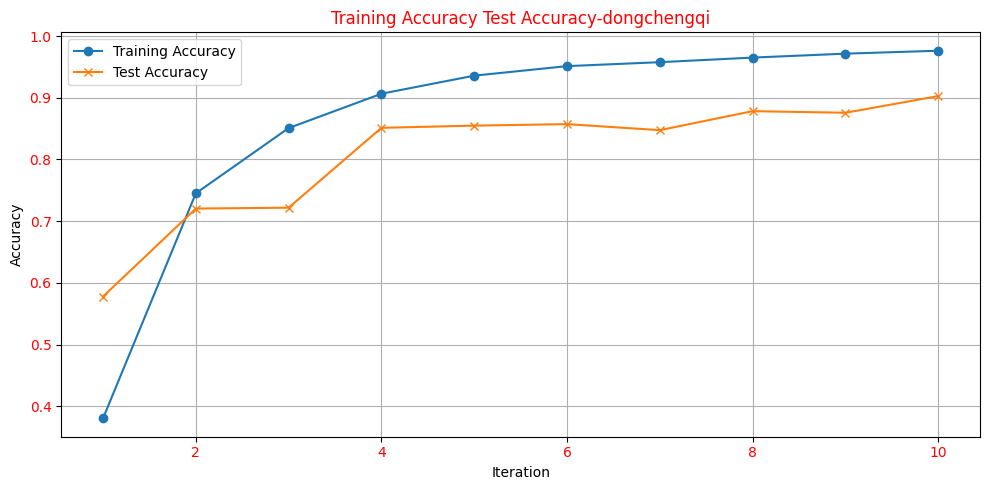

In [35]:
draw(train_accuracies,test_accuracies,num_epoch)

**<font color = green size=6>丁永燚</font>**

In [39]:

cudnn.benchmark = True
plt.ion()
dataset_sizes = {"train": train_dataset.__len__(), "test": test_dataset.__len__()}

def train_model(dataloaders, dataset_sizes, k, num_epochs):
    
#     model = models.resnext50_32x4d(weights='IMAGENET1K_V2')

#     in_ft = model.fc.in_features
#     model.fc = nn.Linear(in_ft, 176)
#     nn.init.xavier_uniform_(model.fc.weight)
#     model = model.to(device)

    model = models.efficientnet_b5(weights='IMAGENET1K_V1')
    in_ft = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_ft, 176)
    nn.init.xavier_uniform_(model.classifier[1].weight)
    
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    # scheduler = ReduceLROnPlateau(optimizer,patience = 2,factor=0.9)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=12)

    os.makedirs('model', exist_ok=True)
    best_model_params_path = os.path.join('model', f'model_{k}.pt')
    since = time.time()

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            #for i,data in enumerate(tqdm(dataloaders[phase],desc=f'{phase} Epoch {epoch}/{num_epochs - 1}'),disable=True):
            for i, data in enumerate(dataloaders[phase]):
                inputs = data[0].to(device)
                labels = data[1].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
   
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step(epoch+1/dataset_sizes['train'])

                # statistics
                running_loss += loss.item() * inputs.size(0)
                if phase =='train':
                    running_corrects += torch.sum(preds == labels)
                else:
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("No.",epoch,f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
        time_elapsed = time.time() - since
        # if phase=='val':
        #     scheduler.step()
        #     print(optimizer.param_groups[0]['lr'])
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
   

In [40]:
train_model(dataloaders,dataset_sizes,k='ef_b5',num_epochs=10)

No. 0 train Loss: 2.5291 Acc: 0.3896
No. 0 test Loss: 2.5031 Acc: 0.3607
No. 1 train Loss: 0.8364 Acc: 0.7453
No. 1 test Loss: 1.8537 Acc: 0.5282
No. 2 train Loss: 0.3988 Acc: 0.8723
No. 2 test Loss: 1.4483 Acc: 0.6302
No. 3 train Loss: 0.2467 Acc: 0.9206
No. 3 test Loss: 0.8611 Acc: 0.7773
No. 4 train Loss: 0.1487 Acc: 0.9515
No. 4 test Loss: 0.4405 Acc: 0.8671
No. 5 train Loss: 0.0839 Acc: 0.9717
No. 5 test Loss: 0.3330 Acc: 0.9052
No. 6 train Loss: 0.0526 Acc: 0.9835
No. 6 test Loss: 0.2961 Acc: 0.9132
No. 7 train Loss: 0.0266 Acc: 0.9913
No. 7 test Loss: 0.2460 Acc: 0.9332
No. 8 train Loss: 0.0173 Acc: 0.9935
No. 8 test Loss: 0.2303 Acc: 0.9328
No. 9 train Loss: 0.0129 Acc: 0.9949
No. 9 test Loss: 0.2139 Acc: 0.9350
Training complete in 10m 22s
